# Práctica 5: Tech evolution. Caso POS Tagging

**Fecha de entrega: 13 de Abril 2025**

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados



In [ ]:
#!jupytext --set-formats ipynb,py 05_Tech_evolution_pos_tagging.ipynb

[jupytext] Reading 05_Tech_evolution_pos_tagging.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py"}}'
[jupytext] Updating 05_Tech_evolution_pos_tagging.ipynb
[jupytext] Updating 05_Tech_evolution_pos_tagging.py


In [294]:
import numpy as np
import torch
from torch import nn
#from torch.utils.data import TensorDataset, DataLoader

### Corpus

#### https://universaldependencies.org/

In [295]:
URL = "https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/refs/heads/master/es_ancora-ud-train.conllu"

In [296]:
import requests
from rich import print as rprint

raw_data = requests.get(URL).text

In [297]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [298]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [299]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [300]:
t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [301]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [302]:
conll_dict = CoNLLDictorizer()

In [303]:
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [304]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

### Preprocesamiento

In [305]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [306]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [307]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [308]:
def extract_features(sentence: list[str], context: int=2) -> list:
    """Extraer las features de cada oración

    Para tener siempre la misma cantidad de features
    por oración aplica un ventaneo llenando los espacios
    restantes con "<BOS>" y "<EOS>"

    Parameters
    ----------
    sentence: list[str]
        Oracion en formato CoNLL
    context: int
        Cantidad de palabras a la izquierda y derecha de la palabra actual. Default: 2

    Return
    ------
    list
        Lista de diccionarios con las features de cada palabra
    """
    start_pad = ["<BOS>"] * context
    end_pad = ["<EOS>"] * context
    sentence = start_pad + sentence + end_pad
    features = []
    for i in range(len(sentence) - 2 * context):
        aux = []
        for j in range(2 * context + 1):
            aux += [sentence[i + j]]
        features += [aux]
    features = [dict(enumerate(feature)) for feature in features]
    return features

In [309]:
def extract_corpus_features(words_set: list[list[str]], pos_tags_set: list[list[str]]):
    """Extraer las features del corpus

    Parameters
    ----------
    words_set: list[list[str]]
        Lista de listas con las palabras de cada oración
    pos_tags_set: list[list[str]]
        Lista de listas con las etiquetas POS de cada oración

    Return
    ------
    tuple
        Tupla con las features y las etiquetas POS
    """
    X_features = [row for sent in words_set for row in extract_features(sent)]
    y_features = [pos for sent in pos_tags_set for pos in sent]
    return X_features, y_features

In [310]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
X_val_features, y_val_features = extract_corpus_features(val_sent_words, val_sent_pos)
X_test_features, y_test_features = extract_corpus_features(test_sent_words, test_sent_pos)

In [311]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

#### Embeddings

In [312]:
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors

In [313]:
vectors = gensim_api.load("glove-wiki-gigaword-100")


In [314]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [315]:
embeddings = get_embeddings(vectors)

#### Indices

In [316]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [317]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [318]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [319]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes


In [320]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [321]:
for sent in t:
    for word in sent:
        print(idx2word[int(word)])

aesthetic
appreciation
and
spanish
art
:
insights
from
eye
-
tracking


In [322]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [323]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [324]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

#### Padding

In [325]:
from torch.nn.utils.rnn import pad_sequence

In [326]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[ 27095,  11243, 220827, 159115, 297329,  89530,  26088, 398992, 230367,
         241295,  69310, 375666, 342254, 389236, 111976,  45561,  90759, 238889,
          55309, 308369, 194136,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [182114, 230367, 241295, 136041,  79148,  58220,  85229,  74400,  65725,
         220827, 106188,  85120, 220827, 389236, 111615, 247400, 135312, 230367,
         206280,  85386,  53880, 308524, 267552, 238414, 220827, 110492, 220827,
          45561,  35738, 359910,  80820,  37607, 194136]])

In [327]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [328]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [329]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

#### Embeddings para RNN

In [330]:
EMBEDDING_DIM = 100

In [331]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [332]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

### La Recurrent Neural Net con pytorch

In [333]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange, tqdm

In [334]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [335]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"Working on device={device}")

Working on device=cuda

In [336]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [337]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

#### Training loop

In [338]:
EPOCHS = 20

In [339]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [340]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [341]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [342]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [343]:
MODELS_PATH = r"C:\Users\diana\OneDrive\Documentos\Escuela\Semestre 8\T.S_PLN\st-cl-2025-2-lab\practicas\dianasalgado22\P5\models\post_taggers\rnn"

In [344]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}


for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

### Obtener 100 embeddings estáticos aleatorios  

In [378]:
import random

In [379]:
# Obtenemos 100 palabras aleatorias del conjunto de entrenamiento
random_words_100 = random.sample(list(vocabulary), 100)
# Obtenemos los embeddings estáticos de las palabras seleccionadas
static_embeddings = {word: embedding_table[word2idx[word]] for word in random_words_100}


In [380]:
len(static_embeddings)

100

### Reducir dimensionalidad

In [381]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convertir a array numpy
words = list(static_embeddings.keys())
embeddings_array = np.array([static_embeddings[word].numpy() for word in words])

tsne = TSNE(n_components=2, random_state=42,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings_array)

###     Aplicar k-means

In [382]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)



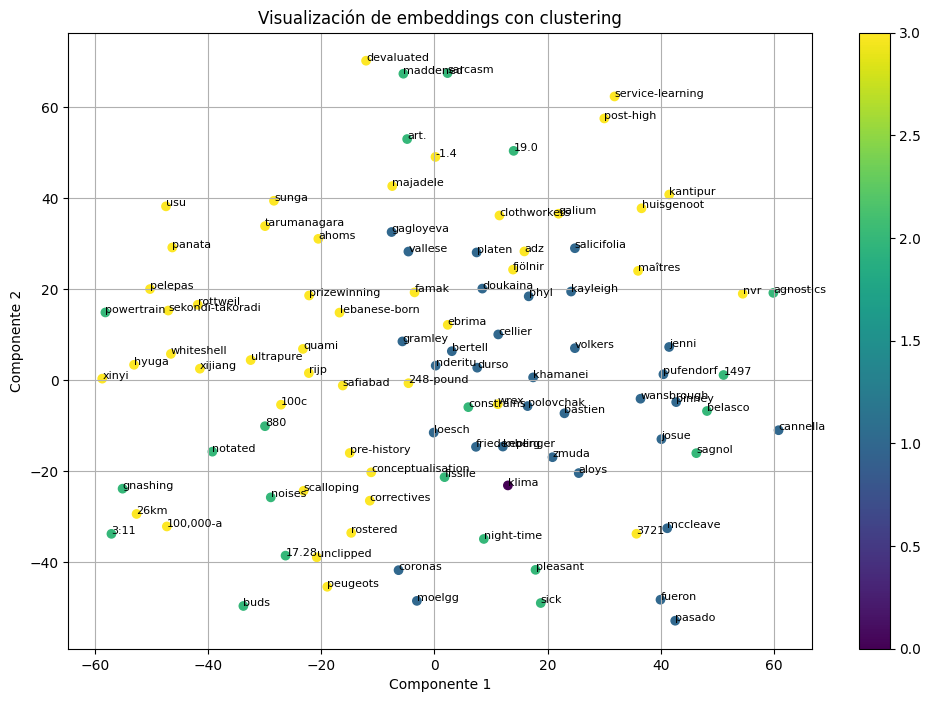

In [383]:
import matplotlib.pyplot as plt


# Visualización
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')

# Añadir etiquetas de palabras
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.colorbar(scatter)
plt.title("Visualización de embeddings con clustering")
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

### Obtener embeddings de las etiquetas POS del modelo RNN

In [370]:
def get_pos_embeddings(model):
    """Extrae los embeddings POS de la capa lineal final"""
    return model.linear.weight.detach().cpu().numpy() 

In [371]:
pos_embeddings_array = get_pos_embeddings(rnn_model)
pos_tags = list(pos2idx.keys())

In [372]:
print(len(pos_embeddings_array))
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
pos_embeddings_2d = tsne.fit_transform(pos_embeddings_array)


20


### Resultado

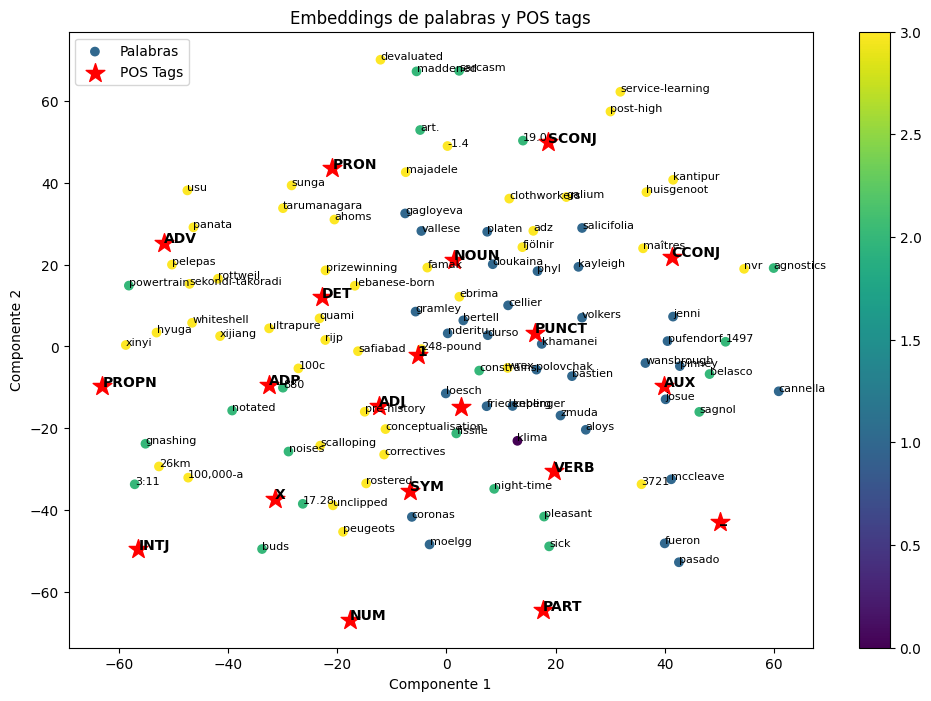

In [384]:
# Añadir al plot anterior
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', label='Palabras')
pos_scatter = plt.scatter(pos_embeddings_2d[:, 0], pos_embeddings_2d[:, 1], 
                         marker='*', s=200, c='red', label='POS Tags')

# Añadir etiquetas
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (pos_embeddings_2d[i, 0], pos_embeddings_2d[i, 1]), fontsize=10, weight='bold')

plt.legend()
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(scatter)
plt.title("Embeddings de palabras y POS tags")
plt.show()

### Conclusion

Se puede notar que las etiquetas POS están separadas en diferentes áreas del gráfico, lo que indica que el modelo puede diferenciar bien las categorías gramaticales. Sin embargo, al revisar las palabras seleccionadas aleatoriamente, algunas no parecen ser del todo correctas o incluso no parecen ser en inglés, lo que dificulta ver si la clasificación está funcionando correctamente. Esto hace que sea más complicado evaluar si el modelo está etiquetando las palabras de forma adecuada. 